In [4]:
import os
import platform
import sys
from os.path import dirname, realpath

import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from matplotlib import colors
import matplotlib
matplotlib.use('QtAgg')
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import itertools
import tifffile as tif
import pandas as pd
import seaborn as sns
from pathlib import Path
import glob
from tqdm import tqdm
from scipy import signal
import scipy.io as sio
from scipy.ndimage import gaussian_filter
import imageio
import argparse
from configparser import ConfigParser
#import napari
import dlc2kinematics
# from pygifsicle import optimize
from get_list_data import expt1_data_list, expt2_data_list
from helper import *
from pylab import *
from matplotlib.path import Path
import matplotlib.patches as patches
from scipy.ndimage import binary_dilation, binary_erosion
import cv2

# data_root = '/media/user/teamshare/nick/behavior/grooming/1p/'
data_root = '/media/user/teamshare/nick/behavior/grooming/2p/'
# data_list = expt1_data_list

data_list = expt2_data_list

# %%

In [5]:
# Define some functions

def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

def preprocess_events(data, ke=7, kd=35):
    data = binary_erosion(data, np.ones((ke,)), iterations=1).astype(data.dtype)
    data = binary_dilation(data, np.ones((kd,)), iterations=1).astype(data.dtype)
    return data

def get_start_end(data):
    
    start_idx = np.where(np.diff(data)==1)[0]
    end_idx = np.where(np.diff(data)==255)[0]

    if data[0]:
        start_idx = np.insert(start_idx, 0, 0)

    if data[-1]:
        end_idx = np.insert(end_idx, len(end_idx), len(data))

    assert len(start_idx) == len(end_idx), 'Length of EVENT START and EVENT END do not match.'
    
    return list(zip(start_idx, end_idx))
    

def merge_events(data1, data2):
    return(data1 | data2)

def save_snippets(file_path, full_video, event_idx, blank_space_size=5):
    for i, event in enumerate(event_idx):
        a, z = event
        groom_snippet = full_video[a:z,:,:]

        # groom_snippet = np.ndarray.transpose(full_video[:,:,a:z], (2, 0, 1))
        tif.imwrite(file_path+"_{}_{}.tif".format(a, z), groom_snippet, photometric='minisblack')
    #     if i == 0:
    #         groom_snippets = full_video[:,:,a:z]
    #     else:
    #         groom_snippets = np.dstack((groom_snippets, np.zeros((full_video.shape[0], full_video.shape[1], blank_space_size)), full_video[:,:,a:z]))
    
    # groom_snippets = np.ndarray.transpose(groom_snippets, (2, 0, 1))
    # tif.imwrite(file_path, groom_snippets, photometric='minisblack')


def get_tracks(file):
    df_dlc = pd.read_csv(file, header=0, skiprows=1)            
    fllx = df_dlc['fll'][1:].to_numpy().astype(np.float32)
    flly = df_dlc['fll.1'][1:].to_numpy().astype(np.float32)
    fllp = df_dlc['fll.2'][1:].to_numpy().astype(np.float32)
    
    flrx = df_dlc['flr'][1:].to_numpy().astype(np.float32)
    flry = df_dlc['flr.1'][1:].to_numpy().astype(np.float32)
    flrp = df_dlc['flr.2'][1:].to_numpy().astype(np.float32)
   
    nosex = df_dlc['nose'][1:].to_numpy().astype(np.float32)
    nosey = df_dlc['nose.1'][1:].to_numpy().astype(np.float32)
    nosep = df_dlc['nose.2'][1:].to_numpy().astype(np.float32)

    return [tuple(np.vstack((fllx, flly, fllp))), tuple(np.vstack((flrx, flry, flrp))), tuple(np.vstack((nosex, nosey, nosep)))]


def draw_ROI_on_figure(str_input='Draw polygon on figure', color='r', delete_fig=True):
    while True:
        pts = []
        tellme(str_input)
        pts = np.asarray(plt.ginput(-1, mouse_stop=MouseButton.RIGHT))
            
        ph = plt.fill(pts[:, 0], pts[:, 1], color, lw=2, alpha=0.5)
            
        tellme('Happy? Key click for yes, mouse click for no')
        if plt.waitforbuttonpress():
            break
    
    if delete_fig:
        plt.close()
    verts = [tuple(i) for i in pts]
    return Path(verts)

In [6]:




for expt in tqdm(data_list):
    mouse_id, list_rec_dir = expt
    # if mouse id to process is passed, process only that mouse
    out_dir = data_root + os.sep + mouse_id +  os.sep + "outputs"
    set_path(out_dir)

    

    # pp = PdfPages(out_dir + os.sep + 'groom_events.pdf')

    for rec_dir in tqdm(list_rec_dir):
        #if recording dir idc is passed, process only that dir
        try:
            dlc_file = glob.glob(data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + mouse_id + '_' + rec_dir + '*1030000.csv')[0]
        except:
            print('DLC csv missing ', mouse_id + os.sep + rec_dir, ' continue to next')
            continue
            
        video_file = glob.glob(data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + mouse_id + '_' + rec_dir + '_trim.mp4')[0]
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            print("Error: Could not open video.")
            break

        frame_number = 100
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if not ret:
            print(f"Error: Could not read frame {frame_number}.")
        cap.release()

        groom_events_file = data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + 'grooming_events_roi_unfiltered.mat'
        groom_events_filtered_file = data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + 'grooming_events_roi_filtered.mat'

        snippets_folder = data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + 'snippets'
        set_path(snippets_folder)
        
        # df_dlc = pd.read_csv(dlc_file, header=0, skiprows=1)      
        tracks = get_tracks(dlc_file)
        fllx, flly, fllp = tracks[0]
        flrx, flry, flrp = tracks[1]
        nosex, nosey, nosep = tracks[2]
        
        if True:#not os.path.isfile(groom_events_file):    
            matplotlib.use('QtAgg')
            fig = plt.figure()           
            plt.imshow(np.mean(frame, axis=2), cmap='gray')
            plt.plot(fllx, flly, alpha=0.3, label='FL L', linewidth=0.5)
            plt.plot(flrx, flry, alpha=0.3, label='FL R', linewidth=0.5)
            plt.plot(nosex, nosey, alpha=0.3, label='Nose', linewidth=0.5)
            plt.axis('off')

            licking_path = draw_ROI_on_figure(str_input='Draw LICKING roi', color='r', delete_fig=False)
            flr_lick_index = licking_path.contains_points(np.vstack((flrx, flry)).T)
            fll_lick_index = licking_path.contains_points(np.vstack((fllx, flly)).T)
            lick_index = flr_lick_index | fll_lick_index

            grooming_path = draw_ROI_on_figure(str_input='Draw GROOMING roi', color='b', delete_fig=True)
            flr_groom_index = grooming_path.contains_points(np.vstack((flrx, flry)).T)
            fll_groom_index = grooming_path.contains_points(np.vstack((fllx, flly)).T)
            
            # flr_groom_index[lick_index] = 0
            # fll_groom_index[lick_index] = 0
 
            # mdic = {"FL_L": fll_index, "FL_R": flr_index, "vertices": verts}
            # sio.savemat(groom_events_file, mdic)
        else:
            mat_contents = sio.loadmat(groom_events_file)
            flr_index = mat_contents['FL_R'][0]
            fll_index = mat_contents['FL_L'][0]

        # flr_events = preprocess_events(flr_index, ke=9, kd=25)
        # fll_events = preprocess_events(fll_index, ke=9, kd=25)

        flr_lick_index1 = preprocess_events(flr_lick_index, ke=20, kd=20).astype(np.uint8)
        fll_lick_index1 = preprocess_events(fll_lick_index, ke=20, kd=20).astype(np.uint8)
        flr_groom_index1 = preprocess_events(flr_groom_index, ke=9, kd=25).astype(np.uint8)
        fll_groom_index1 = preprocess_events(fll_groom_index, ke=9, kd=25).astype(np.uint8)

        # exclude licking events from grooming events
        # flr_groom_index1[fll_lick_index1 | flr_lick_index1] = 0
        # fll_groom_index1[fll_lick_index1 | flr_lick_index1] = 0

        # t = xt(flr_groom_index1, 90)
        # matplotlib.use('Agg')
        # plt.figure()
        # plt.plot(t, fll_events, alpha=0.5, linewidth=0.5)
        # plt.plot(t, flr_events-1.2, alpha=0.5, linewidth=0.5)
        # plt.title(mouse_id + "_" + rec_dir)
        # plt.xlabel('Time (s)')
        # plt.yticks(ticks=[0.5, -0.7], labels=['FL_L', 'FL_R'])
        # plt.show()
        # pp.savefig()
        # plt.close()

        all_groom_events = get_start_end(merge_events(flr_groom_index1, fll_groom_index1))
        event_type = []
        for event in all_groom_events:
            start_idx, end_idx = event
            if flr_groom_index1[start_idx:end_idx].any() and fll_groom_index1[start_idx:end_idx].any():
                event_type.append('bilateral')
            elif flr_groom_index1[start_idx:end_idx].any() and not fll_groom_index1[start_idx:end_idx].any():
                event_type.append('right')
            elif not flr_groom_index1[start_idx:end_idx].any() and fll_groom_index1[start_idx:end_idx].any():
                event_type.append('left')
        all_groom_events = np.asarray(all_groom_events)

        all_lick_events = get_start_end(merge_events(flr_lick_index1, fll_lick_index1)) # merge all lick events
        # event_type = []
        for event in all_lick_events:
            start_idx, end_idx = event
            event_type.append('lick')
            # if flr_lick_index1[start_idx:end_idx].any() and fll_lick_index1[start_idx:end_idx].any():
            #     event_type.append('lick_biltateral')
            # elif flr_lick_index1[start_idx:end_idx].any() and not fll_lick_index1[start_idx:end_idx].any():
            #     event_type.append('lick_right')
            # elif not flr_lick_index1[start_idx:end_idx].any() and fll_lick_index1[start_idx:end_idx].any():
            #     event_type.append('lick_left')
        all_lick_events = np.asarray(all_lick_events)

        



        # # pie chart stuff
        # counts = [(x, event_type.count(x)) for x in set(event_type)]
        # slice_labels = []
        # slice_areas = []
        # for event in counts:
        #     a, b = event
        #     slice_labels.append(a)
        #     slice_areas.append(b)
        # plt.figure()
        # plt.pie(slice_areas, labels=slice_labels)
        # plt.title(mouse_id + "_" + rec_dir)
        # plt.show()
        # pp.savefig()
        # plt.close()
        if all_groom_events.size == 0 and all_lick_events.size == 0:
            continue
        elif all_groom_events.size == 0 and all_lick_events.size != 0:
            all_events = all_lick_events
        elif all_groom_events.size != 0 and all_lick_events.size == 0:
            all_events = all_groom_events
        else:
            all_events = np.vstack((all_groom_events, all_lick_events))
        mdic = {"FL_L": fll_groom_index1, "FL_R": flr_groom_index1, "lick": lick_index, "all_events": all_events, "event_type": event_type}
        # sio.savemat(groom_events_filtered_file, mdic)
        
        b_vid = open_cv_read_video(data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + mouse_id + '_' + rec_dir + '_trim.mp4')
        b_vid = b_vid[:, :, :, 0]
        # mat_contents = sio.loadmat(data_root + os.sep + mouse_id + os.sep + rec_dir + os.sep + mouse_id + '_' + rec_dir + '_svd.mat')
        # U = mat_contents['U']
        # s = mat_contents['s']
        # V = mat_contents['V']
        # b_vid = np.dot(U, np.dot(s, V))
        # b_vid = np.reshape(b_vid, newshape=(107, 214, b_vid.shape[1]))
        
        for ee in set(event_type):
            idx = [ee in i for i in event_type]
            save_snippets(snippets_folder + os.sep + ee, 
                         b_vid, all_events[idx])
        del b_vid
        # del U
        # del s
        # del V
    # pp.close()
        


  0%|                                                     | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_83442/3515202608.py:49: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dlc = pd.read_csv(file, header=0, skiprows=1)


Draw LICKING roi
Happy? Key click for yes, mouse click for no
Draw GROOMING roi
Happy? Key click for yes, mouse click for no




  0%|                                                | 0/109793 [00:00<?, ?it/s]

  0%|                                    | 195/109793 [00:00<00:56, 1943.37it/s]

  1%|▏                                   | 577/109793 [00:00<00:35, 3037.39it/s]

  1%|▎                                   | 881/109793 [00:00<00:39, 2732.34it/s]

  1%|▍                                  | 1260/109793 [00:00<00:34, 3120.35it/s]

  1%|▌                                  | 1626/109793 [00:00<00:32, 3305.08it/s]

  2%|▋                                  | 1961/109793 [00:00<00:34, 3110.83it/s]

  2%|▋                                  | 2285/109793 [00:00<00:34, 3150.20it/s]

  2%|▊                                  | 2673/109793 [00:00<00:31, 3371.38it/s]

  3%|▉                                  | 3076/109793 [00:00<00:29, 3568.72it/s]

  3%|█                                  | 3479/109793 [00:01<00:28, 3705.99it/s]

  4%|█▏                                 | 3885/109793 [00:01<00:27, 3810.26it/s]

  4%|█▎       

In [50]:
flr_lick_index1 = preprocess_events(flr_lick_index, ke=15, kd=0)
fll_lick_index1 = preprocess_events(fll_lick_index, ke=15, kd=10)
flr_groom_index1 = preprocess_events(flr_groom_index, ke=9, kd=25)
fll_groom_index1 = preprocess_events(fll_groom_index, ke=9, kd=25)

flr_groom_index1[fll_lick_index1 | flr_lick_index1] = 0
fll_groom_index1[fll_lick_index1 | flr_lick_index1] = 0

In [11]:
# plt.figure(), plt.plot(fll_lick_index1 ^ flr_lick_index1), plt.show()
# get_start_end(flr_lick_index1)

b_vid = open_cv_read_video(')


100%|███████████████████████████████████████████████████████████████████████████████████| 109617/109617 [00:50<00:00, 2183.76it/s]


In [15]:
for ee in set(event_type):
    idx = [ee in i for i in event_type]
    save_snippets(snippets_folder + os.sep + ee, b_vid, all_events[idx])

In [28]:

test = np.where(np.diff(flr_groom_index1)==1)[0]
test = np.insert(test, len(test), 0)
print(test)

[  8355   8454   8697  12315  12466  12552  13182  13388  13725  13980
  14041  14090  14640  14719  14927  14957  15025  19231  77947  78012
  78698  78819  79492  84431  84552  84597  94229  94282  94314  99500
 104755 104919      0]


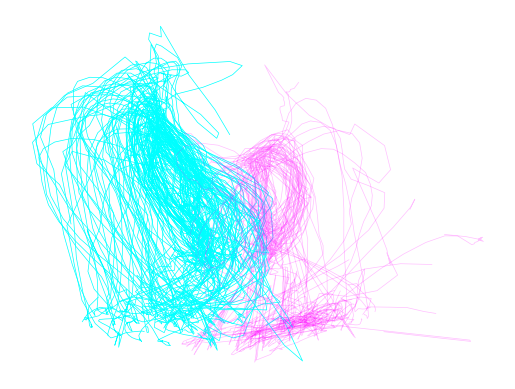

In [30]:
%matplotlib inline

plt.figure()

for i in range(0, len(all_events)):
    a, z = all_events[i]
    plt.plot(flrx[a:z], -flry[a:z], linewidth=0.5, alpha=1, color='cyan')
    plt.plot(fllx[a:z], -flly[a:z], linewidth=0.5, alpha=0.25, color='magenta')
    plt.axis('off')

plt.show()

In [17]:
aa = [1, 2, 3, 4, 5]
bb = [0, 0, 0, 0]

test = list(zip(aa, bb))
print(test)

[(1, 0), (2, 0), (3, 0), (4, 0)]


In [51]:
mat_contents = sio.loadmat('/media/user/teamshare/nick/behavior/grooming/1p/ECR2_thy1/20231116161015/' + os.sep + 'ECR2_thy1_20231116161015_svd.mat')
U = mat_contents['U']
s = mat_contents['s']
V = mat_contents['V']
b_vid = np.dot(U, np.dot(s, V))
b_vid = np.reshape(b_vid, newshape=(107, 214, b_vid.shape[1]))

In [14]:
all_groom_events
# for ee in set(event_type):
#             idx = [ee in i for i in event_type]
#             save_snippets(snippets_folder + os.sep + ee, 
#                          b_vid, all_events[idx])


array([[  8326,    927],
       [  8447,   8423],
       [  8660,   8488],
       [ 12315,  12198],
       [ 12466,  12444],
       [ 12552,  12536],
       [ 13182,  13180],
       [ 13385,  13375],
       [ 13725,  13633],
       [ 13980,  13816],
       [ 14041,  14030],
       [ 14090,  14079],
       [ 14640,  14160],
       [ 14719,  14707],
       [ 14927,  14751],
       [ 14957,  14956],
       [ 15025,  15023],
       [ 19231,  15053],
       [ 29747,  19290],
       [ 36197,  29793],
       [ 36614,  36271],
       [ 77947,  36645],
       [ 78012,  77977],
       [ 78698,  78131],
       [ 78819,  78807],
       [ 79492,  78909],
       [ 84431,  79991],
       [ 84552,  84476],
       [ 84597,  84587],
       [ 94229,  84624],
       [ 94282,  94271],
       [ 94314,  94307],
       [ 99500,  94341],
       [104755,  99533],
       [104919, 104911]])

In [88]:
print(mouse_id)
print(rec_dir)

ETL2_thy1
20231111151220


In [79]:
for i in set(event_type):
    print(i)

biltateral
ipsilateral
contralateral


In [ ]:
t = np.divide(np.array(range(0, len(flr_groom_index1))), 90*60)
plt.figure()
plt.plot(t, merge_events(flr_lick_index1, fll_lick_index1)+1, 'r')
plt.plot(t, merge_events(flr_groom_index1, fll_groom_index1), 'b')
plt.xlabel('Time (mins)')
plt.yticks(ticks=[0.5, 1.5], labels = ['Groom', 'Lick'])
plt.show()

In [49]:
plt.figure(), plt.plot(np.diff((1*flr_lick_index1).astype(np.uint8))), plt.show()

(<Figure size 640x480 with 1 Axes>,
 None)

In [4]:
plt.figure(), plt.plot(all_events[:,0]), plt.show()

(<Figure size 640x480 with 1 Axes>,
 None)

In [16]:
mdic = {"FL_L": fll_groom_index1, "FL_R": flr_groom_index1, "lick": lick_index, "all_events": all_events, "event_type": event_type}
sio.savemat(groom_events_filtered_file, mdic)

In [8]:
len(flr_groom_index1)

109670